In [1]:
import numpy as np
from shape_drawing import Polygon, Line, PyplotViewer, Canvas

### Polygon drawing and transformations

Defining a polygon is simple: Just pass in a name, a list of coordinates, a color and layer number

In [2]:
square = Polygon('my_square', [(1,1), (1,3), (3,3), (3,1)], 'red', 10)

Coordinates of a shape are read-only

In [3]:
square.coordinates

[[1, 1], [1, 3], [3, 3], [3, 1]]

In [4]:
try:
    square.coordinates = [[2,7]]
except AttributeError as e:
    print(e)

can't set attribute


Before we get started, let's also create a viewer. This will let us actually visualize the shapes we draw

In [5]:
viewer = PyplotViewer(figsize=(5,5))

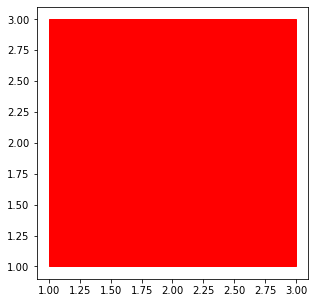

In [6]:
square.view(viewer)

The simple string representation of the output has useful information too. I will explain what "gen_num" is in a bit.

In [7]:
square

shape object <name:my_square|type:Polygon|layer:10|gen_num:0>

We can apply a number of transformations to our shape. There are **translation**, **rotation**(around an arbitary point), **reflection**(across an arbitary line in x-y plane), **union**(with another shape), **intersection**(with another shape), **scale**, **offseting** (also known as dilation, basically adding width to a line) and **arbitary transformation**(user provides a transformation matrix).

Here we apply a rotation of pi/4 around the point (2,2) to the square we just created:

In [8]:
diamond = square.rotate(np.pi/4, origin=[(2,2)])
diamond

shape object <name:my_square|type:Polygon|layer:10|gen_num:1>

Note that the transformed shape is a different object with the same name. The generation number, or "gen_num", is an attribute of the shape and it essentially tells how many transformations it takes to get to the current shape from its ancestor. More details to come

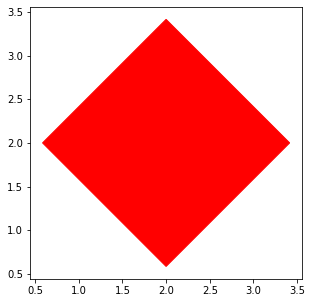

In [9]:
diamond.view(viewer)

Apply another transformation, scaling this time:

In [10]:
diamond_scaled = diamond.scale(0.5)
diamond_scaled

shape object <name:my_square|type:Polygon|layer:10|gen_num:2>

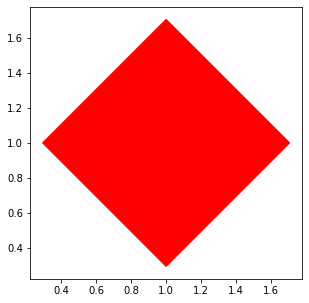

In [11]:
diamond_scaled.view(viewer)

We can actually examine the entire transformation history of a shape by invoking its **traverse_transform_tree()** method, which basically does a *post-order traversal* from its ancestor to itself. The tree shows all the steps, including inputs and transformations involved throughout the shapes evolution.

The output of this traversal is list of TransformTreeDesc, which is a named tuple that contains the ancestrial shapes and transformation at each generation.

For example:

In [12]:
transform_tree = diamond_scaled.traverse_transform_tree()
for node in transform_tree:
    print(node)
    print()

TransformTreeDesc(gen_num=1, inputs=[shape object <name:my_square|type:Polygon|layer:10|gen_num:0>, 0.7853981633974483, [(2, 2)]], transform=ROTATE-->shape object <name:my_square|type:Polygon|layer:10|gen_num:1>)

TransformTreeDesc(gen_num=2, inputs=[shape object <name:my_square|type:Polygon|layer:10|gen_num:1>, 0.5], transform=SCALE-->shape object <name:my_square|type:Polygon|layer:10|gen_num:2>)



It shows that at generation \#1, we took the very first square which started at gen_num 0, applied a rotation with the correspoinding angle(pi/4=0.79) and origin((2,2)) to get to the rotated square at gen_num 1; then at generation \#2, we scaled the square in gen_num 1 by half.

This tree framework will be very useful in a design process to know how different shapes came about. Its usefulness is particularly obvious when we curry/chain different transformations together *without* having to save intermediate shapes.

We will demonstrate this now.

### Transformation currying

Let's apply the following transformations to a shape **all in one go**: a rotation, a scale, an union with another shape, and finally a reflection. In this currying implementation, a nice feature is that **input shapes are not modified and hence preserved**. 


We will first make the second shape that will be unioned during this transformaton chain

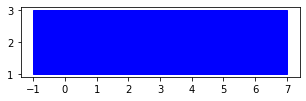

In [13]:
rect = Polygon('random_rectangular', [(-1,1), (-1,3), (7,3), (7,1)], 'blue', 10)
rect.view(viewer)

And now we start, here's the starting shape:

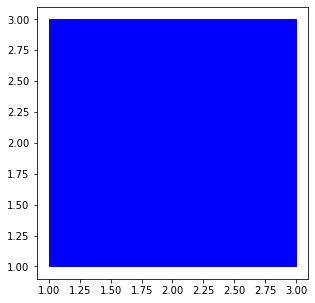

In [14]:
square_start = Polygon('target_square', [(1,1), (1,3), (3,3), (3,1)], 'blue', 10)
square_start.view(viewer)

Currying all the transformations together:

* rotate
* scale
* union
* reflect

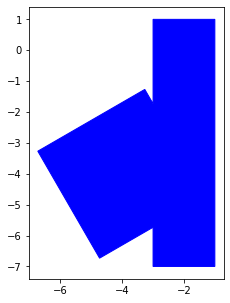

In [15]:
rotate_angle = np.pi / 3
rotate_origin = [(2, 2)]
scale = 2
reflect_line = [(0, 0), (-1, 1)]

shape_final = square_start.rotate(rotate_angle, origin=rotate_origin).scale(scale).union(rect).reflect(reflect_line)
shape_final.view(viewer)

Even though we didn't save any intermediate shapes, we have access to all of them through the transform tree

In [16]:
transform_tree = shape_final.traverse_transform_tree()
for node in transform_tree:
    print(node)
    print()

TransformTreeDesc(gen_num=1, inputs=[shape object <name:target_square|type:Polygon|layer:10|gen_num:0>, 1.0471975511965976, [(2, 2)]], transform=ROTATE-->shape object <name:target_square|type:Polygon|layer:10|gen_num:1>)

TransformTreeDesc(gen_num=2, inputs=[shape object <name:target_square|type:Polygon|layer:10|gen_num:1>, 2], transform=SCALE-->shape object <name:target_square|type:Polygon|layer:10|gen_num:2>)

TransformTreeDesc(gen_num=3, inputs=[shape object <name:target_square|type:Polygon|layer:10|gen_num:2>, shape object <name:random_rectangular|type:Polygon|layer:10|gen_num:0>], transform=UNION-->shape object <name:target_square|type:Polygon|layer:10|gen_num:3>)

TransformTreeDesc(gen_num=4, inputs=[shape object <name:target_square|type:Polygon|layer:10|gen_num:3>, [(0, 0), (-1, 1)]], transform=REFLECT-->shape object <name:target_square|type:Polygon|layer:10|gen_num:4>)



We can easily access an intermediate shape, for example if we want to see just before the final reflection:

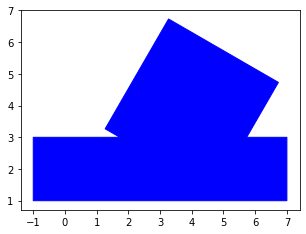

In [17]:
transform_tree[3].inputs[0].view(viewer)

### Polygon properties

Area

In [18]:
transform_tree[3].inputs[0].area()

25.999999997766274

Perimeter

In [19]:
transform_tree[3].inputs[0].perimeter()

29.790302291346805

Bounding box

In [20]:
transform_tree[3].inputs[0].bounds()

array([[-1.        ,  1.        ],
       [-1.        ,  6.73205081],
       [ 7.        ,  6.73205081],
       [ 7.        ,  1.        ]])

### Line drawing and transformation

Similar API as polygon (they both inherit from BaseShape class):

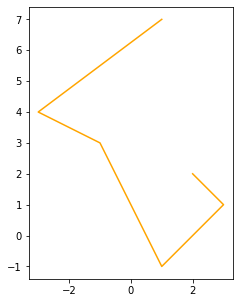

In [21]:
simple_line = Line('my line', [(2,2), (3,1), (1,-1), (-1,3), (-3,4), (1,7)], color='orange', layer=10)
simple_line.view(viewer)

In [22]:
simple_line.width

0

In [23]:
simple_line.perimeter()

15.950844619618655

Apply offsets such that the line looks "dilated" and has a width:

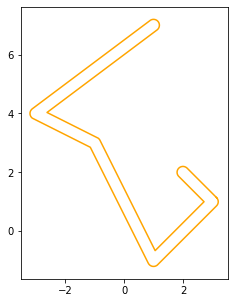

In [24]:
dilated = simple_line.offset(0.2)
dilated.view(viewer)

*Note that the dilated shape is actually a different class now*

In [25]:
dilated

shape object <name:my line|type:DilatedLine|layer:10|gen_num:1>

In [26]:
dilated.perimeter()

49.87516259090645

Since it's derived from the Polygon class and we can also apply polygon boolean operation on it with other polygons!

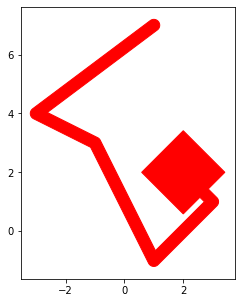

In [27]:
diamond_plus_line = diamond.union(dilated)
diamond_plus_line.view(viewer)

###  Canvas -- the drawing board

So far we have just drawn indivudal shapes and left them alone in memory after creation. Now I show how we can orgnize them and store them, basically having a drawing board! This is where Canvas comes in

In [28]:
canvas = Canvas()

Canvas allows you to draw on it directly or add existing shapes:

In [29]:
canvas.draw_polygon('my_rectangular', [(1,1), (1,2), (3,2), (3,1)], 'blue', 11)
canvas.draw_polygon('my_triangle', [(4,1), (5,7), (8, 3)], 'purple', 5)
canvas.add_shape(diamond_plus_line)

In [30]:
canvas

shape object <name:my_rectangular|type:Polygon|layer:11|gen_num:0>
---------------------------------------
shape object <name:my_triangle|type:Polygon|layer:5|gen_num:0>
---------------------------------------
shape object <name:my_square|type:Polygon|layer:10|gen_num:2>
---------------------------------------
total number of top shape objects in this canvas: 3

We can view an individual shape:

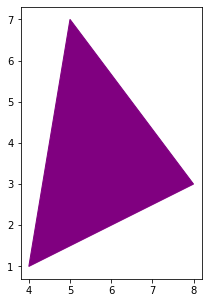

In [31]:
canvas['my_triangle'].view(viewer)

Or all together:

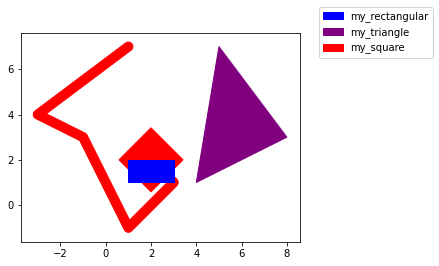

In [32]:
canvas.view(viewer, show_label=True)

We can remove shapes:

In [33]:
canvas.remove_shape('my_rectangular')
canvas

shape object <name:my_triangle|type:Polygon|layer:5|gen_num:0>
---------------------------------------
shape object <name:my_square|type:Polygon|layer:10|gen_num:2>
---------------------------------------
total number of top shape objects in this canvas: 2

Each shape has a **top** attribute which points to the final transformed shape coming from it, essentially the root of the transform tree. When we store or draw a shape on the canvas object, it has access only to this "top" shape. This way, when we add a shape and later transform it, canvas has the most up-to-date version of it:

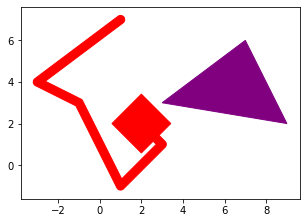

In [34]:
canvas['my_triangle'].rotate(np.pi/2, origin=[(6,4)])
canvas.view(viewer)